In [6]:
import numpy as np
import networkx as nx
import EoN
import matplotlib.pyplot as plt
import csv, random, pdb, sys
from IPython.core.debugger import set_trace
import copy

In [7]:
import os
print("PYTHONPATH:", os.environ.get('PYTHONPATH'))
print("PATH:", os.environ.get('PATH'))

PYTHONPATH: /Users/ahsantarique/.vscode/extensions/ms-toolsai.jupyter-2020.12.414227025/pythonFiles:/Users/ahsantarique/.vscode/extensions/ms-toolsai.jupyter-2020.12.414227025/pythonFiles/lib/python
PATH: /usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin


In [40]:

'''
Cvacc[i] = cost of vaccination for node i
Cinf[i]: cost of infection for node i
x[i]: current strategy of node i
    x[i] = 1 ==> i is vaccinated
S(x): set of vaccinated nodes
comp(x): components formed by residual nodes
cost[i]: cost of node i

#Evaluating reduction in cost for node i
#return old cost - new cost
def reduction_in_cost(x, comp, cost, Cvacc, Cinf, i)
    if x[i] == 0, then return  cost[i] - Cvacc[i]
    if x[i] == 1
        A = {comp(j, x): j is a nbr of i }
        N = \sum_{X in A} |X|
        return  Cvacc[i] - N^2 Cinf[i]/n

#best response
def best_respose(Cvacc, Cinf)
    xinit: random strategy
    initialize comp, cost
    for t = 1.. T:
        for i in V:
            if reduction_in_cost(x, i) > 0:
                flip x[i]
                update comp

#possible efficiencies
    #uniform Cvacc, Cinf setting
        if there is a large comp X: check benefit of vaccination
        if all comp are small: check benefit of not vaccinating
'''


#each line: id1, id2
def read_graph(fname):
    G = nx.Graph()
    fp_reader = csv.reader(open(fname), delimiter = ' ')
    headers = next(fp_reader) 
    count = 0
    for line in fp_reader:
        if line[1] != line[2]: 
            G.add_edge(line[1], line[2])
        count += 1
        if count >= 1000:
            break
    return G

#create components
#x: strategy vector where x[i] = 1 means i is vaccinated
def init_comp(G, x):

    # comp_id: {node u: component_id i}; mapping of each node to it's current component id
    # comp_len: {component_id i: length(int)}; mapping of component id to its length
    # comp_d: {component_id i: list of node in ith component}
    # max_comp_id: integer; each time we create a new component id so it will be helpful.
    comp_id = {}; comp_len = {}; comp_d = {}; max_comp_id = 0
    
    H = nx.Graph()
    for u in G.nodes(): 
        H.add_node(u)
    for e in G.edges():
        u = e[0]; v = e[1]
        if x[u] == 0 and x[v] == 0: #both nodes unvacccinated
            H.add_edge(u, v)
    comp = nx.connected_components(H)
    
    for c in list(comp):
        max_comp_id += 1
        for u in c: 
            comp_id[u] = max_comp_id
        comp_len[max_comp_id] = len(list(c))
        comp_d[max_comp_id] = list(c)

    return H, comp_d, comp_id, comp_len, max_comp_id

def comp_cost(G, x, Cvacc, Cinf, p):
    cost = {}
    #calculate #unvacc nbrs for each node
    H = nx.Graph()
    for e in G.edges():
        H.add_edge(e[0], e[1])
    for i in x:
        if x[i] == 1: 
            cost[i] = Cvacc[i]
        else: 
            cost[i] = (1 + p*(H.degree(i)))/(len(x)+0.0)
    return cost


#return reduction in cost if node u flips its strategy
def reduction_in_cost(G, x, p, cost, Cvacc, Cinf, u):
    if x[u] == 0: 
        return  cost[u] - Cvacc[u]
    if x[u] == 1:
        num_unvacc_nbrs = 0
        for v in G.neighbors(u): 
            if x[v] == 0: num_unvacc_nbrs += 1
        return cost[u] - (1 + p*num_unvacc_nbrs)/(len(x)+0.0)


def check_NE(G, x, p, cost, Cvacc, Cinf):
    num_violated = 0
    for u in G.nodes():
        if reduction_in_cost(G, x, p, cost, Cvacc, Cinf, u) > 0: num_violated += 1
    return num_violated
            
#flip strategy of node u
def update_strategy(G, x, p, cost, Cvacc, Cinf, u):

    if x[u] == 0:
        x[u] = 1
        cost[u] = Cvacc[u]
        return x, cost

    else: #x[u] = 1
        x[u] = 0
        num_unvacc_nbrs = 0
        for v in G.neighbors(u): 
            if x[v] == 0: num_unvacc_nbrs += 1
        cost[u] = (1 + p*num_unvacc_nbrs)/(len(x)+0.0)
        
        return x, cost
        
def print_analysis(comp_id, comp_len): 
    component_ids = np.unique(list(comp_id.values()))  
    component_lengths = [comp_len[i] for i in component_ids] 
    avg_comp_size = round(np.mean(component_lengths),2)
    max_comp_size = np.max(component_lengths)
    #print("Average component size: ", avg_comp_size)
    #print("Max component size: ", max_comp_size) 
    return avg_comp_size, max_comp_size  

#start at strategy x and run for T steps
def best_response(G, Cvacc, Cinf, x, T, p, epsilon=0.05):
#     if len(x) == 0:
#         for u in G.nodes(): x[u] = np.random.randint(0, 2)
    
    #H, comp_d, comp_id, comp_len, comp_max_id = init_comp(G, x)
    #print('x', x)
    cost = comp_cost(G, x, Cvacc, Cinf, p)
    V = G.nodes(); itrn = 0
    for t in range(T):
        #u = random.choice(list(V)); 
        num_updated = 0
        for u in G.nodes():
#             itrn += 1
#             if (itrn % 10 == 0): print(itrn)
            if reduction_in_cost(G, x, p, cost, Cvacc, Cinf, u) > 0:
                x, cost = update_strategy(G, x, p, cost, Cvacc, Cinf, u)
                num_updated += 1

        if num_updated == 0: return x, check_NE(G, x, p, cost, Cvacc, Cinf)
    
    return x, check_NE(G, x, p, cost, Cvacc, Cinf)


def save_file(filename, data):
    with open(filename, 'w') as f:
        for row in data:
            for item in row:
                f.write("%s\t" % item)
            f.write("\n")


def save_degree_hist(comp_id, comp_len, comp_d, G, alpha):     
    component_ids = np.unique(list(comp_id.values()))  
    component_lengths = [comp_len[i] for i in component_ids] 
    index_max = np.argmax(component_lengths)
    max_comp = component_ids[index_max]
    max_comp_nodes = comp_d[max_comp]
    max_nodes_degrees = [G.degree(node) for node in max_comp_nodes]
    plt.hist(max_nodes_degrees, density=False, bins=20)  # `density=False` would make counts
    plt.ylabel('Num of nodes')
    plt.xlabel('Degree');
    plt.title("Histogram of degrees for Max Component Nodes; alpha: " + str(alpha) + "; len: " + str(len(max_comp_nodes)))
    plt.savefig("../out/fig/max_comp_nodes_alpha_" + str(alpha) + ".png")
    plt.show()

def save_graph_data(comp_id, comp_len, comp_d, G):     
    graph_data = {}
    graph_data['comp_id'] = comp_id
    graph_data['comp_len'] = comp_len
    graph_data['comp_d'] = comp_d
    graph_data['nodes'] = list(G.nodes())
    graph_data['edges'] = list(G.edges())
    graph_data['degree'] = dict(G.degree)
    return graph_data



def remove_topk_nodes(G, k):
    degree_tup = list(dict(G.degree).items())
    degree_tup = sorted(degree_tup, key=lambda x: -1*x[1])
    top_k_nodes = [x for x,d in degree_tup[:k]]
    G_res = copy.deepcopy(G)
    for node in top_k_nodes:
        G_res.remove_node(node)
    
    return G_res

def exp_infsize(G, x, p):
    num_itrn = 100
    z = 0
    for i in range(num_itrn):
        H = nx.Graph()
        for u in G.nodes(): 
            if x[u] == 0: H.add_node(u)
        for e in G.edges():
            if x[e[0]] == 0 and x[e[1]] == 0 and random.random() <= p:
                H.add_edge(e[0], e[1])
        comp = nx.connected_components(H)
        z1 = 0
        for c in list(comp):
            a = len(list(c))
            z1 += a*a
        z += z1/(len(x)+0.0)
        
    return z/(num_itrn*len(x)+0.0)



def get_topk_nodes(G, k):
    degree_tup = list(dict(G.degree).items())
    degree_tup = sorted(degree_tup, key=lambda x: -1*x[1])
    top_k_nodes = [x for x,d in degree_tup[:k]]
    return top_k_nodes

In [79]:
if __name__ == '__main__':
### run for a fixed network and fixed alpha
##########################################
    
    T = 100
    epsilon = 0.001
    alphavals = np.arange(0,50,1)
    #alphavals = sys.argv[1]

    num_times = 1



    avg_file_name = './vacc_albemarle_household_1_7_dec7_avg.txt'
    raw_file_name = './vacc_albemarle_household_1_7_dec7_raw.txt' 
    
    raw_data = []
    np.random.seed(0)

    #### read from a fixed graph
    #G = read_graph('household_undirected_albe_1.90.txt')

    n = 10000; m = 3
    G = nx.barabasi_albert_graph(n, m)
    
    p = 0.4; T = 100

    exp_inf_list = []
    exp_inf_std = []

    n_vacc_size = []

    xlist = []

    for alpha in alphavals:
        zs = []
        vacc_size = []
        for i in range(num_times):
            x = {}; Cvacc = {}; Cinf = {};
            for u in G.nodes():
                x[u] = np.random.randint(0, 2)
                Cinf[u] = 1; 
                Cvacc[u] = Cinf[u]*float(alpha)/n
                
            x, nviol = best_response(G, Cvacc, Cinf, x, T, p, epsilon)

            if(nviol == 0):
                z = exp_infsize(G, x, p)
                zs.append(z)

                vaccinated = len([i for i in x if x[i] == 1])
                vacc_size.append(vaccinated)

                xlist.append(x)

        n_vacc_size.append(vacc_size)

        zs = np.array(zs)
        exp_inf_list.append(zs.mean())
        exp_inf_std.append(zs.std())
    
    n_vacc_size = np.array(n_vacc_size)


In [80]:
# print(exp_inf_list)
# print(exp_inf_std)
mean_vacc_size = n_vacc_size.mean(axis = 1)
# print(xlist)
# print(n_vacc_size)


 7778: 0, 7779: 0, 7780: 0, 7781: 0, 7782: 0, 7783: 0, 7784: 0, 7785: 0, 7786: 0, 7787: 0, 7788: 0, 7789: 0, 7790: 0, 7791: 0, 7792: 0, 7793: 0, 7794: 0, 7795: 0, 7796: 0, 7797: 0, 7798: 0, 7799: 0, 7800: 0, 7801: 0, 7802: 0, 7803: 0, 7804: 0, 7805: 0, 7806: 0, 7807: 0, 7808: 0, 7809: 0, 7810: 0, 7811: 0, 7812: 0, 7813: 0, 7814: 0, 7815: 0, 7816: 0, 7817: 0, 7818: 0, 7819: 0, 7820: 0, 7821: 0, 7822: 0, 7823: 0, 7824: 0, 7825: 0, 7826: 0, 7827: 0, 7828: 0, 7829: 0, 7830: 0, 7831: 0, 7832: 0, 7833: 0, 7834: 0, 7835: 0, 7836: 0, 7837: 0, 7838: 0, 7839: 0, 7840: 0, 7841: 0, 7842: 0, 7843: 0, 7844: 0, 7845: 0, 7846: 0, 7847: 0, 7848: 0, 7849: 0, 7850: 0, 7851: 0, 7852: 0, 7853: 0, 7854: 0, 7855: 0, 7856: 0, 7857: 0, 7858: 0, 7859: 0, 7860: 0, 7861: 0, 7862: 0, 7863: 0, 7864: 0, 7865: 0, 7866: 0, 7867: 0, 7868: 0, 7869: 0, 7870: 0, 7871: 0, 7872: 0, 7873: 0, 7874: 0, 7875: 0, 7876: 0, 7877: 0, 7878: 0, 7879: 0, 7880: 0, 7881: 0, 7882: 0, 7883: 0, 7884: 0, 7885: 0, 7886: 0, 7887: 0, 7888: 0, 

In [95]:
"1.1"
vacc = []
for x in xlist:
    if (sum(x.values()) != len(get_provax(x))):
        print(len(get_provax(x)))
        break
    vacc.append(sum(x))


: 1, 7780: 1, 7781: 1, 7782: 1, 7783: 1, 7784: 1, 7785: 1, 7786: 1, 7787: 1, 7788: 1, 7789: 1, 7790: 1, 7791: 1, 7792: 1, 7793: 1, 7794: 1, 7795: 1, 7796: 1, 7797: 1, 7798: 1, 7799: 1, 7800: 1, 7801: 1, 7802: 1, 7803: 1, 7804: 1, 7805: 1, 7806: 1, 7807: 1, 7808: 1, 7809: 1, 7810: 1, 7811: 1, 7812: 1, 7813: 1, 7814: 1, 7815: 1, 7816: 1, 7817: 1, 7818: 1, 7819: 1, 7820: 1, 7821: 1, 7822: 1, 7823: 1, 7824: 1, 7825: 1, 7826: 1, 7827: 1, 7828: 1, 7829: 1, 7830: 1, 7831: 1, 7832: 1, 7833: 1, 7834: 1, 7835: 1, 7836: 1, 7837: 1, 7838: 1, 7839: 1, 7840: 1, 7841: 1, 7842: 1, 7843: 1, 7844: 1, 7845: 1, 7846: 1, 7847: 1, 7848: 1, 7849: 1, 7850: 1, 7851: 1, 7852: 1, 7853: 1, 7854: 1, 7855: 1, 7856: 1, 7857: 1, 7858: 1, 7859: 1, 7860: 1, 7861: 1, 7862: 1, 7863: 1, 7864: 1, 7865: 1, 7866: 1, 7867: 1, 7868: 1, 7869: 1, 7870: 1, 7871: 1, 7872: 1, 7873: 1, 7874: 1, 7875: 1, 7876: 1, 7877: 1, 7878: 1, 7879: 1, 7880: 1, 7881: 1, 7882: 1, 7883: 1, 7884: 1, 7885: 1, 7886: 1, 7887: 1, 7888: 1, 7889: 1, 7890:

In [81]:
# np.random.seed(0)
# n = 1000; m = 2
# G = nx.barabasi_albert_graph(n, m)

k = mean_vacc_size.astype(int)
topk_list = [get_topk_nodes(G, i) for i in k]

zs = []
for knodes in topk_list:
    x = {}
    for i in G.nodes: x[i] = 0
    for i in knodes: x[i] = 1

    z = exp_infsize(G, x, p)

    zs.append(z)


[0.0,
 0.0,
 0.00018187060000000006,
 0.0004958325999999999,
 0.1040163246,
 0.23733999000000003,
 0.36600466239999996,
 0.42993129980000006,
 0.4858545619999998,
 0.512355614,
 0.5317426865999998,
 0.5645556657999997,
 0.584749788,
 0.5815126254000003,
 0.6046411263999998,
 0.6100626778000002,
 0.6186820708000003,
 0.6249143081999998,
 0.6299877293999999,
 0.6346127758000001,
 0.6353145783999997,
 0.6437785889999997,
 0.6496763480000001,
 0.6501349800000001,
 0.6504257678000002,
 0.6544689458,
 0.6544516519999998,
 0.6604117579999998,
 0.6698045559999999,
 0.6658233529999998,
 0.6676941191999999,
 0.6725777985999997,
 0.6728403874000001,
 0.670275989,
 0.6676349041999998,
 0.6688259710000004,
 0.6715005799999997,
 0.6722504322,
 0.6750658521999998,
 0.6829266656000001,
 0.6703863609999998,
 0.6716517211999998,
 0.6803454814,
 0.6792739203999999,
 0.6760823834,
 0.6818480109999998,
 0.6795306962000003,
 0.6794568699999999,
 0.6832325662000004,
 0.6852531796000003]

Text(0, 0.5, 'Jaccard Index')

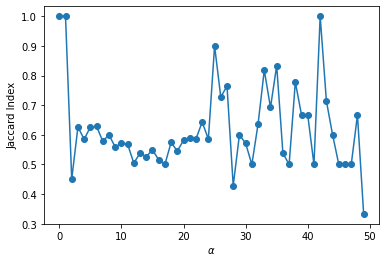

In [88]:
# set(topk_list[0])

from util import *
from strategy_vector_manipulator import *

jaccard = []
for x, knodes in zip(xlist, topk_list):
    vacc = get_provax(x)
    v = intersect(set(vacc), set(knodes))
    u = union(set(vacc), set(knodes))

    jaccard.append(len(v)/len(u))

plt.plot(alphavals, jaccard, 'o-')
plt.xlabel(r'$\alpha$')
plt.ylabel('Jaccard Index')

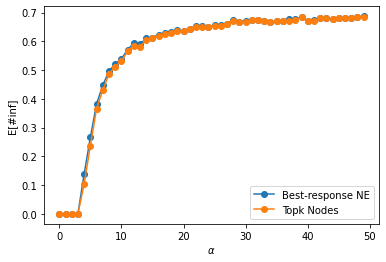

In [83]:
p4 = exp_inf_list
exp_inf = [p4]
zs
legend = ['Best-response NE', 'Topk Nodes']

for y in exp_inf:
    plt.plot(alphavals, y, 'o-')

    plt.plot(alphavals, zs, 'o-')


plt.xlabel(r'$\alpha$')
plt.ylabel('E[#inf]')
#ax.set_title('Montgomery county network')
plt.legend(legend)
#plt.savefig('out/montgomery_p0.0435.png')

In [32]:
p1 = [0.0, 0.0, 0.001356834, 0.0016395199999999998, 0.0017922860000000001, 0.0018332099999999996, 0.001955692, 0.002190552, 0.002336868, 0.00224686, 0.002278218, 0.0024380020000000003, 0.00243888, 0.002432844, 0.002446016, 0.0024340580000000002, 0.0024152019999999995, 0.0024434439999999995, 0.0024258120000000003, 0.00240963, 0.0024208999999999993, 0.002444848, 0.002440438, 0.002436532000000001, 0.002401036, 0.002471888, 0.0024298059999999996, 0.002452676, 0.0024213999999999998, 0.0024878699999999997, 0.0024694300000000003, 0.0024251560000000004, 0.002455742, 0.002419895999999999, 0.0024030559999999998, 0.0024264799999999995, 0.0024256200000000003, 0.0024405039999999996, 0.0024268000000000002, 0.002446722, 0.0024319320000000004, 0.0024316060000000002, 0.0024240699999999995, 0.002456836, 0.0024099399999999997, 0.00242308, 0.002425132, 0.0024358619999999996, 0.0024190439999999995, 0.002453242]

p1std = [0.0, 0.0, 2.0913899779811447e-05, 3.620937116272522e-05, 6.0146648152660676e-05, 8.462854234831206e-05, 0.0001919547478339623, 0.00024221060558117632, 0.00018773009374098757, 0.00025216656780786774, 0.00023812349391859672, 5.785566693073376e-05, 8.18047177123666e-05, 3.544601393668972e-05, 6.203690114762359e-05, 3.670562730699464e-05, 5.271578924762506e-05, 6.882671504583042e-05, 5.280955989212564e-05, 7.294630641780262e-05, 2.7444052178932914e-05, 0.00010627293134189898, 4.384673894373436e-05, 5.6350647343220465e-05, 3.328743042050544e-05, 7.12370236323781e-05, 4.7888730240005434e-05, 6.280535824274885e-05, 9.325865879370139e-05, 5.190917086604282e-05, 4.217512276212136e-05, 4.237057639447438e-05, 5.9044651205676574e-05, 3.4728634640595864e-05, 4.933430757596541e-05, 5.839804517276251e-05, 4.6820413496679357e-05, 6.669287686102634e-05, 4.491435761535511e-05, 5.8366704515502445e-05, 6.552969903791713e-05, 5.2227654015856466e-05, 4.5141383452437426e-05, 5.999273742712543e-05, 6.783803240071171e-05, 7.494933808913864e-05, 5.1349082328704014e-05, 5.5226105747191896e-05, 7.623100461098448e-05, 7.081774322865682e-05]

p2 = [0.0, 0.0, 0.001433094, 0.00229778, 0.003246438, 0.0054734119999999995, 0.0063207720000000005, 0.009647584, 0.011403241999999997, 0.011688994, 0.018351849999999996, 0.021807776000000004, 0.02137006, 0.024006704, 0.025558040000000004, 0.027090784, 0.026034968000000002, 0.02435717, 0.030239804000000002, 0.026383914, 0.025560657999999997, 0.027828916, 0.033203998, 0.032424176000000006, 0.033350304000000004, 0.03305050599999999, 0.033515408000000003, 0.032742716000000005, 0.03390515, 0.034068462, 0.033070576000000004, 0.033305382, 0.033790572, 0.033872104, 0.033763548, 0.033100166, 0.034020301999999995, 0.032939858, 0.03304262200000001, 0.033061815999999994, 0.033410362, 0.033844877999999995, 0.033522164, 0.033364534, 0.033005528, 0.03289569399999999, 0.033490278, 0.033634569999999996, 0.03329368000000001, 0.033927238]


p2std = [0.0, 0.0, 2.6374609077671896e-05, 0.00010421973172101317, 0.00025291540205372976, 0.001281367805595255, 0.0016920341228521367, 0.002700414651831085, 0.0034772955248520364, 0.0029575507494147934, 0.000578771866852562, 0.006071327243302241, 0.005739868626921701, 0.007353070853790544, 0.007796270007787055, 0.008054266027619397, 0.0074322110647004665, 0.007532755729459177, 0.005894631439591794, 0.0078085787194344175, 0.00743295107009564, 0.007556190378886969, 0.0014945141264089815, 0.001583434986952103, 0.001671320201488625, 0.0011981728923006025, 0.0011210140729964084, 0.0012035204543272204, 0.0009947552466913585, 0.0009580495551045312, 0.0011726105722805033, 0.0011804075840640864, 0.0010661374964309204, 0.001728546351679351, 0.0012335714209789383, 0.0014961566556761369, 0.0007758427924496027, 0.0013663026341905373, 0.0012059619695645484, 0.0012307009247676647, 0.0014696319430782608, 0.0013464344551874761, 0.0014173241831789928, 0.0011970119226490626, 0.0014176789477790821, 0.0014026249993223435, 0.0014267298696095164, 0.0017053663941863043, 0.0009843993326287869, 0.00148784951847826]

p3 = [0.0, 0.0, 0.001560314, 0.0031529300000000004, 0.006212870000000001, 0.014188239999999996, 0.02099983, 0.033674192000000006, 0.05152563000000001, 0.06753388400000002, 0.078577432, 0.092475028, 0.11264394800000002, 0.113822118, 0.11529896999999997, 0.12726294600000002, 0.13594339800000005, 0.133452898, 0.16783603399999997, 0.15094014, 0.16379042399999993, 0.163244178, 0.168203638, 0.16660676600000002, 0.166618448, 0.15708966, 0.16688868799999998, 0.17600677599999998, 0.163739398, 0.16394582600000002, 0.158689138, 0.16745515000000002, 0.17414242, 0.17200094400000002, 0.15892515199999996, 0.18793758, 0.18705350199999998, 0.18563104600000002, 0.186001252, 0.18696160999999997, 0.18758192199999998, 0.18637813, 0.18668103, 0.185801126, 0.18634369, 0.18785227799999996, 0.187246696, 0.185594664, 0.187286782, 0.18583261399999995]

p3std = [0.0, 0.0, 8.379074032373757e-05, 0.00033266932184979135, 0.0007182670536924278, 0.00377560911443968, 0.004026687968514571, 0.00815096456743716, 0.021589780899694655, 0.014765562284954273, 0.03163095161906604, 0.023718059968478367, 0.026406349326481608, 0.012430052460589047, 0.013259863438329208, 0.016308841750304778, 0.012402065427969471, 0.01351448498018169, 0.018783813427804386, 0.019710145424638555, 0.019115159712991773, 0.01929892798923185, 0.020417846036144823, 0.018991543207061496, 0.019595609224707863, 0.015460081270575509, 0.019782242652688704, 0.01843714165854956, 0.01962423396598084, 0.019057320768001054, 0.017959311774600834, 0.019989681594303105, 0.01824181200141257, 0.019680909141656665, 0.016415910963116724, 0.002633434230065378, 0.002296185289412858, 0.002380954650253575, 0.002307572977016323, 0.0018187566476963962, 0.0020603341843972787, 0.0025722656752715204, 0.0014346271489763516, 0.001823023711684541, 0.002500933911293951, 0.00289286540153461, 0.0014462114632044756, 0.0019527171063069893, 0.002855339661020381, 0.002368503282531795]

p4 = [0.0, 0.0, 0.001481984, 0.0031443239999999996, 0.009401722000000001, 0.029607764, 0.06067971, 0.10363233599999999, 0.153822308, 0.18284513800000002, 0.213303794, 0.23223928000000002, 0.26314762599999997, 0.265251792, 0.31327799800000006, 0.30961402600000004, 0.312122954, 0.30362928599999994, 0.330901828, 0.3544949, 0.37452981400000007, 0.37077028000000006, 0.37483434400000004, 0.368068752, 0.38126724599999995, 0.39660730000000005, 0.397572104, 0.401242356, 0.403184506, 0.40486870999999985, 0.402905432, 0.403221516, 0.40280686999999993, 0.403048218, 0.403434544, 0.404050158, 0.40382640599999997, 0.40243373799999993, 0.403100568, 0.40260349, 0.40438719799999995, 0.40537511400000004, 0.40118677199999997, 0.404333234, 0.4040706620000001, 0.40422561999999995, 0.40245741399999996, 0.40306282200000004, 0.404899568, 0.40370057]

p4std = [0.0, 0.0, 3.989599458592297e-05, 0.0002759866635618465, 0.0022981952626084674, 0.007101842809703975, 0.015235575480287575, 0.016737412771029563, 0.026461700272474104, 0.029547284642130436, 0.02387129339506519, 0.034882775592830366, 0.03211406429879726, 0.024426428810719242, 0.031116369855173576, 0.02441371099051359, 0.03474121221133429, 0.01744917368692979, 0.02715774157345666, 0.032513208761727586, 0.02335676654213599, 0.013140068529133353, 0.02869337879436412, 0.0176499336920051, 0.017889052225159522, 0.01165323532454398, 0.011432640325687887, 0.001893072903441385, 0.002166512443814747, 0.0021823391684016196, 0.003374204594451257, 0.002213626394689028, 0.002810529410146822, 0.003308235442243509, 0.002752584032225708, 0.0020882475265820246, 0.0036182267996358874, 0.0014579671259791636, 0.003771599400426313, 0.003029068104130421, 0.002035889766042271, 0.003265324087536166, 0.002554600470886976, 0.0016174850493540483, 0.00337149598423554, 0.003200973861461557, 0.00405439130445051, 0.0028993829777584934, 0.003415075620143104, 0.003101474412420674]


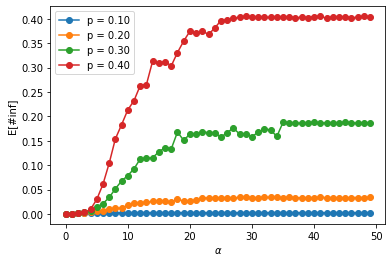

In [38]:
p = [p1, p2, p3, p4]
pstd = [p1std, p2std, p3std, p4std]
legend = ['p = ' + str('%0.2f'%i) for i in np.arange(0.1, 0.5, 0.1)]
for y in p:
    plt.plot(alphavals, y, 'o-')

plt.xlabel(r'$\alpha$')
plt.ylabel('E[#inf]')
#ax.set_title('Montgomery county network')
plt.legend(legend)
#plt.savefig('out/montgomery_p0.0435.png')

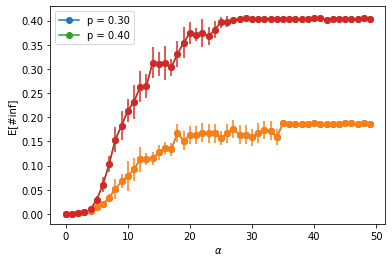

In [39]:
p = [p3, p4]
pstd = [p3std, p4std]
legend = ['p = ' + str('%0.2f'%i) for i in np.arange(0.3, 0.5, 0.1)]
for y,e in zip(p,pstd):
    plt.plot(alphavals, y, 'o-')
    plt.errorbar(alphavals, y, e, fmt='o-')

plt.xlabel(r'$\alpha$')
plt.ylabel('E[#inf]')
#ax.set_title('Montgomery county network')
plt.legend(legend)
#plt.savefig('out/montgomery_p0.0435.png')

In [22]:
max([G.degree(v) for v in G.nodes()])

103